# Introduction to Cross Validation and Model Selection

In a previous lab you created a model with l2 or ridge regularization and l1 or lasso regularization. In both cases, an apparently optimum value of the regularization parameter was found. This process is an example of **model selection**. The goal of model selection is to find the best performing model for the problem at hand. Model selection is a very general term and can apply to at least the following common cases:
- Selection of optimal model **hyperparameters**. Hyperparameters are parameters which determine the characteristics of a model. Hyperparameters are distinct from the model parameters. For example, for the case of l2 regularized regression, the degree of regularization is determined by a hyperparameter, which is distinct from the regression coefficients or parameters. 
- **Feature selection** is the process of determining which features should be used in a model. 
- Comparing different model types is an obvious case of model selection. 

If you are thinking that the model selection process is closely related to model training, you are correct. Model selection is a component of model training. However, one must be careful, as applying a poor model selection method can lead to an over-fit model!

## Overview of k-fold cross validation

The questions remain, how good are the hyperparameter estimates perviously obtained for the l2 and l1 regularization parameters and are there better ways to estimate these parameters? The answer to both questions is to use **resampling methods**. Resampling methods repeat a calculation multiple times using randomly selected subsets of the complete dataset.  In fact, resampling methods are generally the best approach to model selection problems. 


**K-folod Cross validation** is a widely used resampling method. In cross validaton a dataset is divided into **k folds**. Each fold contains $\frac{1}{k}$ cases and is created by **Bernoulli random sampling** of the full data set. A computation is performed on $k-1$ folds of the full dataset. The $k^{th}$ fold is **held back** and is used for testing the result. The compuation is performed $k$ times and model parameters are averaged (mean taken) over the results of the $k$ folds. For each iteration, $k-1$ folds are used for training and the $k^{th}$ fold is used for testing. 

4-fold cross validation is illustrated in the figure below. To ensure the data are randomly sampled the data is randomly shuffled at the start of the procedure. The random samples can then be efficiently sub-sampled as shown in the figure. The model is trained and tested four times. For each iteration the data is trained with three folds of the data and tested with the fold shown in the dark shading. 

<img src="img/CrossValidation.jpg" alt="Drawing" style="width:750px; height:400px"/>
<center> **Resampling scheme for 4-fold cross validation**</center>

## Introduction to nested cross validation

Unfortunately, simple cross validation alone does not provide an unbiased approach to model selection. The problem with evaluating model performance with simple cross validation uses the same data samples as the model selection process. This situation will lead to model over fitting wherein the model selection is learned based on the evaluation data. The result is usually unrealistically optimistic model performance estimates.

To obtain unbiased estimates of expected model performance while performing model selection, it is necessary to use **nested cross validation**. As the name implies, nested cross validation is performed though a pair of nested CV loops. The outer loop uses a set of folds to perform model evaluation. The inner loop performs model selection using another randomly sampled set of  folds not used for evalution by the outer loop. This algorithm allows model selection and evaluation to proceed with randomly sampled subsets of the full data set, thereby avoiding model selection bias. 

## Cross validation and compuational efficiency

As you may have surmised, cross validation can be compuationally intensive. Processing each fold of a cross validation requires fitting and evaluating the model. It is desireable to compute a reasonable number of folds. Since the results are averaged over the folds, a small number of folds can lead to significant variablity in the final result. However, with large data sets or complex models, the number of folds must be limited in order to complete the cross validation process in a reasonable amount of time. It is, therefore, necessary to trade off accuracy of the cross validation result with the practical consideration of the required compuatational resources. 

As mentioned earlier, other resampling methods exist. For example, leave-one-out resampling has the same number of folds as data cases. Such methods provide optimal unbiased estimates of model performance. Unfortunately, as you might think, such methods are compuationally intensive and are only suitable for small datasets. In practice k-fold cross validation is a reasonable way to explore bias-variance trade-off with reasonable compuational resources. 

## Prepare the data set

With the above theory in mind, you will now try an example. 

As a first step, execute the code in the cell below to load the packages required for this notebook. 

In [103]:
## Import packages
library(ggplot2)
library(repr)
library(dplyr)
library(caret)
library(glmnet)
library(ROCR)

options(repr.plot.width=5, repr.plot.height=5) # Set the initial plot area dimensions

Next, load the preprocessed files containing the features and the labels. The preprocessing includes the following:
1. Cleaning missing values.
2. Aggregate categories of certain categorical variables. 

Execute the code in the cell below to load the features and labels as numpy arrays for the example. 

In [104]:
credit = read.csv('German_Credit_Preped.csv')
print(dim(credit))
names(credit)

[1] 999  23


[1] "X"                        "Customer_ID"             
 [3] "checking_account_status"  "loan_duration_mo"        
 [5] "credit_history"           "purpose"                 
 [7] "loan_amount"              "savings_account_balance" 
 [9] "time_employed_yrs"        "payment_pcnt_income"     
[11] "gender_status"            "other_signators"         
[13] "time_in_residence"        "property"                
[15] "age_yrs"                  "other_credit_outstanding"
[17] "home_ownership"           "number_loans"            
[19] "job_category"             "dependents"              
[21] "telephone"                "foreign_worker"          
[23] "bad_credit"

### Code the label

The R Caret package computes most performance metrics using the positive cases. For example, recall is a measure of correct classification of positive cases. Therefore, it is important to have the coding of the label correct. The code in the cell below creates a factor (categorical) variable and coerces the levels of the label column, `bad_credit`. Execute this code. 

In [105]:
temp = credit$bad_credit
credit$bad_credit <- ifelse(credit$bad_credit == 0, 'good', 'bad')
credit$bad_credit <- factor(credit$bad_credit, levels = c("bad", "good"))
credit$bad_credit[1:10]

[1] bad  good good bad  good good good good bad  bad 
Levels: bad good

The label is not coded as factors in the order required. 

### Scale numeric features

Cross validation will be used to train the model. Since folds will be selected from the entire dataset the numeric features are scaled in batch. Execute the code in the cell below to accomplish this: 

In [113]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
             'time_in_residence', 'age_yrs', 'number_loans', 'dependents')

preProcValues <- preProcess(credit[,num_cols], method = c("center", "scale"))
credit[,num_cols] = predict(preProcValues, credit[,num_cols])
head(credit[,num_cols])

loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
2.2464282,0.9483849,-0.86876113,-0.7645835,-1.19202026,-0.7035652,-0.4283287
-0.7397312,-0.4170067,-0.86876113,0.1414888,1.18945982,-0.7035652,2.3323187
1.7487350,1.6323204,-0.86876113,1.0475610,0.83664795,-0.7035652,2.3323187
0.2556552,0.5655086,0.02505181,1.0475610,1.54227168,1.0276211,2.3323187
1.2510417,2.0477820,-0.86876113,1.0475610,-0.04538171,-0.7035652,2.3323187
0.2556552,-0.1552623,0.02505181,1.0475610,1.54227168,-0.7035652,-0.4283287


## Optimize hyperparameters with nested cross validation

Given often observed variability in metrics in cross validation, performing model selection from a single training and evaluation is an uncertain proposition at best. Fortunately, the nested cross validation approach provides a better way to perform model selection. However, there is no guarantee that a model selection process will, in fact, improve a model. In some cases, it may be that model selection has minimal impact. 

The inner cross validation loop is used to find the optimal hyperparameters. The general process is:
1. A grid of hyperparameters is defined. The model selection will be performed by comparing performance metrics over this grid. 
2. The folds for the cross validation are defined.
3. For each set of folds models are computed for each combination of hyperparameters from the grid. 
4. The Average metrics of each model (hyperparameter combination) is computed. The best model is selected based on these averages.

Once the inner cross validation determines optimal hyperparameters, a final cross validation is performed to determine how well the final model is expected to perform. This process is know as the inner loop of the nested CV. Notice that by creating these independent fold objects there is no need to actually create nested loops for this process. While conceptually nesting the inner and out loops is not hard, is computationally intensive and is generally avoided.  

### Inner loop

The code in the cell below uses the capabilities of the Caret package to perform the inner loop of the cross validation as follows:
1. The 'trainControl' object defines a 10 fold cross validation. The `twoClassSummary` function defines the ROC metric as th one used for model selection. 
2. The `train` function defines the following:
  - The model is defined with the R modeling language.
  - The data frame to be used specified.
  - The `method` argument specifies the R model to use.
  - Optional arguments, such as `weights` for the model are defined. 
  - The metric to be used for model evaluation is specified. 
  - The `trainControl` object is specified.

Execute this code and examine the results:

In [114]:
## Create a weight vector for the training cases.
weights = ifelse(credit$bad_credit == 'bad', 0.66, 0.34)

fitControl = trainControl(method = 'cv',
                         number = 10,
                         classProbs = TRUE,
                         summaryFunction = twoClassSummary)

set.seed(9999)
cv_mod_roc = train(bad_credit ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property,
                 data = credit, 
                 method = "glmnet", 
                 weights = weights, 
                 metric="ROC",
                 trControl = fitControl)
    
cv_mod_roc

glmnet 

999 samples
 10 predictor
  2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 899, 899, 899, 899, 899, 899, ... 
Resampling results across tuning parameters:

  alpha  lambda       ROC        Sens       Spec     
  0.10   0.000296246  0.7701511  0.6366667  0.7409524
  0.10   0.002962460  0.7709641  0.6400000  0.7395238
  0.10   0.029624601  0.7725673  0.6366667  0.7495238
  0.55   0.000296246  0.7704838  0.6400000  0.7409524
  0.55   0.002962460  0.7715832  0.6500000  0.7409524
  0.55   0.029624601  0.7700469  0.6466667  0.7266460
  1.00   0.000296246  0.7708661  0.6433333  0.7395238
  1.00   0.002962460  0.7722919  0.6500000  0.7395238
  1.00   0.029624601  0.7592747  0.6700000  0.6966460

ROC was used to select the optimal model using the largest value.
The final values used for the model were alpha = 0.1 and lambda = 0.0296246.

The grid of hyperpameters searched by the Caret package is over `alpha` and `ambda`. The printed tables shows the values of the metrics as a function of the parameters in the search grid. Sens is short for sensitivity which is the same as global recall and Spec is specificity which is the true negative rate $= \frac{TN}{TN + FP}$

As an alternative, recall can be used as the model selection metric. The code in the cell below uses the `prSummary` function in the `trainControl` object and the `Recall` as the `metric`. Execute this code and examine the results.

In [112]:
## Create a weight vector for the training cases.
weights = ifelse(credit$bad_credit == 'bad', 0.66, 0.34)

fitControl = trainControl(method = 'repeatedcv',
                         number = 10,
                         repeats = 5,
                         classProbs = TRUE,
                         summaryFunction = prSummary)

set.seed(9999)
cv_mod_recall = train(bad_credit ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property,
                 data = credit, 
                 method = "glmnet", 
                 weights = weights, 
                 metric="Recall",
                 trControl = fitControl)
    
cv_mod_recall

glmnet 

999 samples
 10 predictor
  2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 899, 899, 899, 899, 899, 899, ... 
Resampling results across tuning parameters:

  alpha  lambda       AUC        Precision  Recall     F        
  0.10   0.000296246  0.5753613  0.5253972  0.6526667  0.5797238
  0.10   0.002962460  0.5757260  0.5244736  0.6533333  0.5794721
  0.10   0.029624601  0.5719016  0.5284786  0.6460000  0.5789299
  0.55   0.000296246  0.5751138  0.5251588  0.6526667  0.5795396
  0.55   0.002962460  0.5758161  0.5228870  0.6486667  0.5766209
  0.55   0.029624601  0.5630046  0.5163738  0.6600000  0.5773171
  1.00   0.000296246  0.5753606  0.5249237  0.6526667  0.5794589
  1.00   0.002962460  0.5758664  0.5255511  0.6506667  0.5787695
  1.00   0.029624601  0.5408680  0.5033709  0.6826667  0.5777324

Recall was used to select the optimal model using the largest value.
The final values used for the model

The results of the second CV are nearly the same as the first one.

You can illustrate the performance of the different models over the hyperparameter grid. Execute the code in the cell below to create this display. 

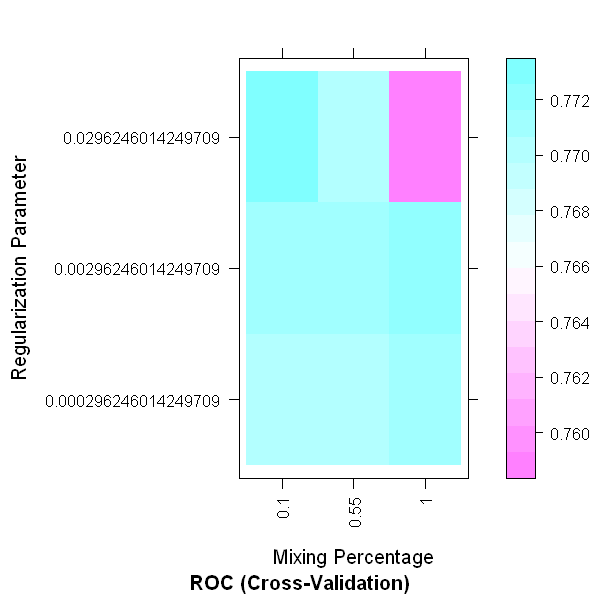

In [115]:
plot(cv_mod_roc, metric = "ROC", plotType = "level",
     scales = list(x = list(rot = 90)))

You can see that the best model in the upper left. 

### Outer loop

With the model selected, you will now perform the outer loop of the cross validation to verify the performance of the model. Consistent performance across the folds indicates that the model is likely to generalize well when faced with new data values. 

The code in the cell below executes the outside CV loop:
1. The parameter grid is specified to have only the optimal hyperparameters. 
2. The `trainControl` object uses the `savePredictions` and `returnResamp` arguments to save the results of each of the folds. 
3. The `tuneGrid` argument of the `train` function is used to specify the parameter grid. 

Execute this code and examine the results:

In [119]:
## Set the hyperparameter grid to the optimal values from the inside loop
paramGrid <- expand.grid(alpha = c(1), lambda = c(0.0296246))

fitControl = trainControl(method = 'cv',
                         number = 10,
                         returnResamp="all",
                         savePredictions = TRUE,
                         classProbs = TRUE,
                         summaryFunction = twoClassSummary)

set.seed(9999)
cv_mod_outer = train(bad_credit ~ loan_duration_mo + loan_amount +  
                                 payment_pcnt_income + age_yrs + 
                                 checking_account_status + credit_history + 
                                 purpose + gender_status + time_in_residence +
                                 property,
                 data = credit, 
                 method = "glmnet", 
                 weights = weights, , 
                 tuneGrid = paramGrid, 
                 metric="ROC",
                 trControl = fitControl)
    
print_metrics = function(mod){
    means = c(apply(mod$resample[,1:3], 2, mean), alpha = mod$resample[1,4], 
                lambda = mod$resample[1,5], Resample = 'Mean')
    stds = c(apply(mod$resample[,1:3], 2, sd), alpha = mod$resample[1,4], 
                lambda = mod$resample[1,5], Resample = 'STD')
    out = rbind(mod$resample, means, stds)
    out[,1:3] = lapply(out[,1:3], function(x) round(as.numeric(x), 3))
    out
}
print_metrics(cv_mod_outer)

ROC,Sens,Spec,alpha,lambda,Resample
0.832,0.800,0.700,1,0.0296246,Fold01
0.716,0.567,0.686,1,0.0296246,Fold02
0.819,0.767,0.743,1,0.0296246,Fold03
0.786,0.600,0.771,1,0.0296246,Fold04
0.781,0.633,0.743,1,0.0296246,Fold05
0.827,0.767,0.729,1,0.0296246,Fold06
0.722,0.600,0.743,1,0.0296246,Fold07
0.726,0.667,0.652,1,0.0296246,Fold08
0.746,0.700,0.657,1,0.0296246,Fold09
0.640,0.600,0.543,1,0.0296246,Fold10


Notice the following about these results: 
1. There is variation in the three performance metrics from fold to fold. This variation gives you an idea of the variability to be expected when the model is placed in production.
2. The mean of each metric summarizes the expected performance of the model. 
3. The standard deviation of each metric summarizes the variability. You can see that the standard deviation is approximately an order of magnitude less than the metric. 

In summary, these results indicate this model is likely to generalize well since the variation in the performance metrics is limited. 

## Summary

In this lab you have performed by simple cross validation and nested cross validation. Key points and observations are:
1. Model selection should be done using a resampling procedure such as nested cross validation. The nested sampling structure is required to prevent bias in model selection wherein the model selected learns the best hyperparameters for the samples used, rather than a model that generalizes well. 
2. There is significant variation in model performance from fold to fold in cross validation. This variation arrises from the sampling of the data alone and is not a property of any particular mdoel.
3. Given the expected sampling variation in cross validation, there is generally considerable uncertainty as to which model is best when performing model selection.  
4. The results of the outer loop of the nested cross validation is indicative of the ability of a model to generalize. 